## Image classification with CNN

In [13]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# import albumentations as A
#from autoaugment import CIFAR10Policy

Device Configuration

In [14]:
# CUDA for PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda
NVIDIA GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [15]:
# Hyper-parameters 
num_epochs = 5
batch_size = 64
learning_rate = 0.01

## Step1_Data for our image classification 🔄

In [16]:
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.002, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [17]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),transforms.ToTensor()
     ])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

torch.Size([64, 1, 28, 28])
torch.Size([3, 242, 242])


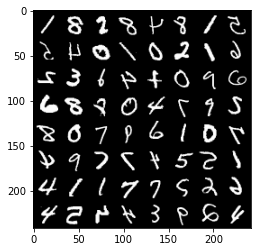

In [23]:
## just for visualisation
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    print(img.shape)
    img = img    # unnormalize
    npimg = img.numpy()
    #print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Step2_Network architecture 🤖

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) #output layer
        
        return x

## Step3_Model ingredients

In [20]:
net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Step5_Model Training - forward, backward, weight updates

In [21]:
def train(model, train_loader, val_loader=None,  epochs = 15, save = False):
    for epoch in range(epochs): 
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        net.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in testloader:
                    inputs, labels = data
                    outputs = net(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(net.state_dict(), "save_"+str(epoch)+".pth")

In [22]:
train(net, trainloader, testloader,  save=False)

ValueError: Expected input batch_size (16) to match target batch_size (64).

In [37]:
all_preds = []
all_labels = []
net.eval()

with torch.no_grad():
    for i, data in enumerate(testloader):
        print('Batch [%4d / %4d]' % (i+1, len(testloader)))
        inputs, labels = data
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

Batch [   1 /  157]
Batch [   2 /  157]
Batch [   3 /  157]
Batch [   4 /  157]
Batch [   5 /  157]
Batch [   6 /  157]
Batch [   7 /  157]
Batch [   8 /  157]
Batch [   9 /  157]
Batch [  10 /  157]
Batch [  11 /  157]
Batch [  12 /  157]
Batch [  13 /  157]
Batch [  14 /  157]
Batch [  15 /  157]
Batch [  16 /  157]
Batch [  17 /  157]
Batch [  18 /  157]
Batch [  19 /  157]
Batch [  20 /  157]
Batch [  21 /  157]
Batch [  22 /  157]
Batch [  23 /  157]
Batch [  24 /  157]
Batch [  25 /  157]
Batch [  26 /  157]
Batch [  27 /  157]
Batch [  28 /  157]
Batch [  29 /  157]
Batch [  30 /  157]
Batch [  31 /  157]
Batch [  32 /  157]
Batch [  33 /  157]
Batch [  34 /  157]
Batch [  35 /  157]
Batch [  36 /  157]
Batch [  37 /  157]
Batch [  38 /  157]
Batch [  39 /  157]
Batch [  40 /  157]
Batch [  41 /  157]
Batch [  42 /  157]
Batch [  43 /  157]
Batch [  44 /  157]
Batch [  45 /  157]
Batch [  46 /  157]
Batch [  47 /  157]
Batch [  48 /  157]
Batch [  49 /  157]
Batch [  50 /  157]


In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds);
cm

array([[756,   9,  39,  48,  53,   7,  12,  24,  31,  21],
       [ 26, 803,   5,  17,  12,   7,  13,   6,  18,  93],
       [ 82,   3, 415, 131, 183,  68,  53,  43,  10,  12],
       [ 16,   7,  26, 613,  94, 108,  48,  55,   7,  26],
       [ 20,   4,  22,  79, 719,  37,  40,  71,   7,   1],
       [ 13,   1,  12, 251,  52, 561,  24,  73,   4,   9],
       [  9,  11,  12, 116,  54,  32, 735,  15,   7,   9],
       [ 14,   3,   7,  70,  59,  46,   1, 784,   0,  16],
       [121,  24,  10,  42,  28,   9,   6,   7, 701,  52],
       [ 39,  50,   9,  52,  11,   6,   6,  25,  22, 780]], dtype=int64)

In [39]:
import itertools
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Normalized confusion matrix


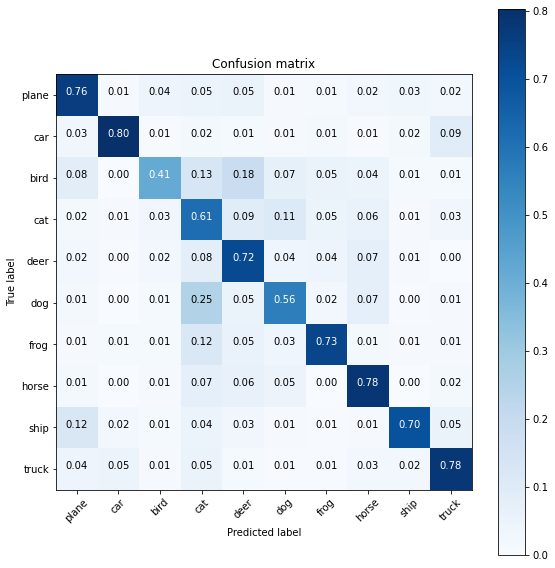

In [41]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes), normalize=True)